# Imports

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
import numpy as np

# Reading the csvs

In [4]:
# Load Datasets
accidents_df = pd.read_csv("US_Accidents_March23.csv", parse_dates=["Start_Time"])
pollution_df = pd.read_csv("Pollution_2000_2023.csv", parse_dates=["Date"])

# Preparation of the datasets

In [5]:
# Prepare Columns for Matching
accidents_df['Date'] = pd.to_datetime(accidents_df['Start_Time']).dt.normalize()
pollution_df['Date'] = pd.to_datetime(pollution_df['Date']).dt.normalize()

accidents_df['City'] = accidents_df['City'].astype(str).str.upper().str.strip().str.replace(r'[^A-Z ]', '', regex=True)
pollution_df['City'] = pollution_df['City'].astype(str).str.upper().str.strip().str.replace(r'[^A-Z ]', '', regex=True)

In [22]:
state_abbrev_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

state_abbrev_reverse = {v: k for k, v in state_abbrev_map.items()}

pollution_df['State'] = pollution_df['State'].map(state_abbrev_map)
accidents_df['State'] = accidents_df['State'].astype(str).str.upper().str.strip()
pollution_df['State'] = pollution_df['State'].astype(str).str.upper().str.strip()

# Similarity Metrics

In [7]:
# Create CityState strings
accidents_df['CityState'] = accidents_df['State'] + '-' + accidents_df['City']
pollution_df['CityState'] = pollution_df['State'] + '-' + pollution_df['City']

# Fuzzy match City only
accident_cities = accidents_df['City'].dropna().unique().tolist()
pollution_df['Resolved_City'] = pollution_df['City'].apply(
    lambda x: process.extractOne(x, accident_cities, scorer=fuzz.ratio, score_cutoff=85)[0]
    if process.extractOne(x, accident_cities, scorer=fuzz.ratio, score_cutoff=85)
    else None
)

# Fuzzy match CityState
accident_citystates = accidents_df['CityState'].dropna().unique().tolist()
pollution_df['Resolved_CityState'] = pollution_df['CityState'].apply(
    lambda x: process.extractOne(x, accident_citystates, scorer=fuzz.ratio, score_cutoff=90)[0]
    if process.extractOne(x, accident_citystates, scorer=fuzz.ratio, score_cutoff=90)
    else None
)

# Data fusion strategies

In [8]:
#Data Fusion Strategy 1: Most Recent Matching City-State (based on pollution recency)
pollution_df['CityState'] = pollution_df['State'] + '-' + pollution_df['City']
accidents_df['CityState'] = accidents_df['State'] + '-' + accidents_df['City']

# Choose most recent pollution reading for each CityState-Date
pollution_recent = pollution_df.sort_values('Date').drop_duplicates(subset=['Date', 'CityState'], keep='last')



In [9]:
# Data Fusion Strategy 2: Filter for Accidents Near Pollution Stations
# Approximate pollution station location from pollution data (rounded lat/lng)
station_locations = pollution_df[['City', 'State']].drop_duplicates()
filtered_accidents = accidents_df[accidents_df[['City', 'State']].apply(tuple, axis=1).isin(station_locations.apply(tuple, axis=1))]

# Creation of the data mart


In [10]:
# Merge to Create Accidents-Pollution Datamart
pollution_recent['City'] = pollution_recent['City'].astype(str).str.upper().str.strip()
filtered_accidents['City'] = filtered_accidents['City'].astype(str).str.upper().str.strip()

accidents_pollution_dm = pd.merge(
    pollution_recent,
    filtered_accidents,
    on=['City', 'State', 'Date'],
    how='inner'
)

accidents_pollution_dm = accidents_pollution_dm[[
    'Date', 'City', 'State', 'Start_Time', 'Severity',
    'CO Mean', 'NO2 Mean', 'O3 Mean', 'SO2 Mean'
]]

accidents_pollution_dm

C:\Users\joaol\AppData\Local\Temp\ipykernel_46492\3711811343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_accidents['City'] = filtered_accidents['City'].astype(str).str.upper().str.strip()


,Date,City,State,Start_Time,Severity,CO Mean,NO2 Mean,O3 Mean,SO2 Mean
0,2016-02-08,CINCINNATI,OH,2016-02-08 06:15:39,2,0.2250,9.625000,0.020588,0.787500
1,2016-02-08,CINCINNATI,OH,2016-02-08 06:15:39,2,0.2250,9.625000,0.020588,0.787500
2,2016-02-08,CINCINNATI,OH,2016-02-08 07:53:43,3,0.2250,9.625000,0.020588,0.787500
3,2016-02-08,CINCINNATI,OH,2016-02-08 15:43:50,2,0.2250,9.625000,0.020588,0.787500
4,2016-02-08,CINCINNATI,OH,2016-02-08 16:50:57,2,0.2250,9.625000,0.020588,0.787500
...,...,...,...,...,...,...,...,...,...
1222191,2023-03-31,RALEIGH,NC,2023-03-31 16:53:58,2,0.2250,6.130435,0.036059,0.043478
1222192,2023-03-31,PITTSBURGH,PA,2023-03-31 16:38:00,2,0.3125,18.565000,0.034941,0.478261
1222193,2023-03-31,PITTSBURGH,PA,2023-03-31 15:40:30,2,0.3125,18.565000,0.034941,0.478261
1222194,2023-03-31,CONCORD,CA,2023-03-31 17:06:00,2,-0.0625,4.826087,0.027882,0.604348


In [11]:
# Identify duplicated Start_Time entries
duplicate_times = accidents_pollution_dm['Start_Time'].duplicated(keep='first')

# Drop all but the first occurrence
accidents_pollution_dm = accidents_pollution_dm[~duplicate_times]


In [12]:
accidents_pollution_dm["Start_Time"].value_counts()

2016-02-08 06:15:39    1
2021-01-19 19:23:49    1
2021-01-19 16:40:13    1
2021-01-19 16:50:32    1
2021-01-19 17:00:14    1
                      ..
2018-12-12 06:48:37    1
2018-12-12 07:10:03    1
2018-12-12 07:23:40    1
2018-12-12 07:45:55    1
2023-03-31 20:18:00    1
Name: Start_Time, Length: 1061886, dtype: int64

# Analysis of the data

C:\Users\joaol\AppData\Local\Temp\ipykernel_46492\1986478088.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_pollution_dm[f'{var}_Level'] = np.where(accidents_pollution_dm[var] > median_val, 'High', 'Low')
C:\Users\joaol\AppData\Local\Temp\ipykernel_46492\1986478088.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_pollution_dm[f'{var}_Level'] = np.where(accidents_pollution_dm[var] > median_val, 'High', 'Low')
C:\Users\joaol\AppData\Local\Temp\ipykernel_46492\1986478088.py:9: Setti

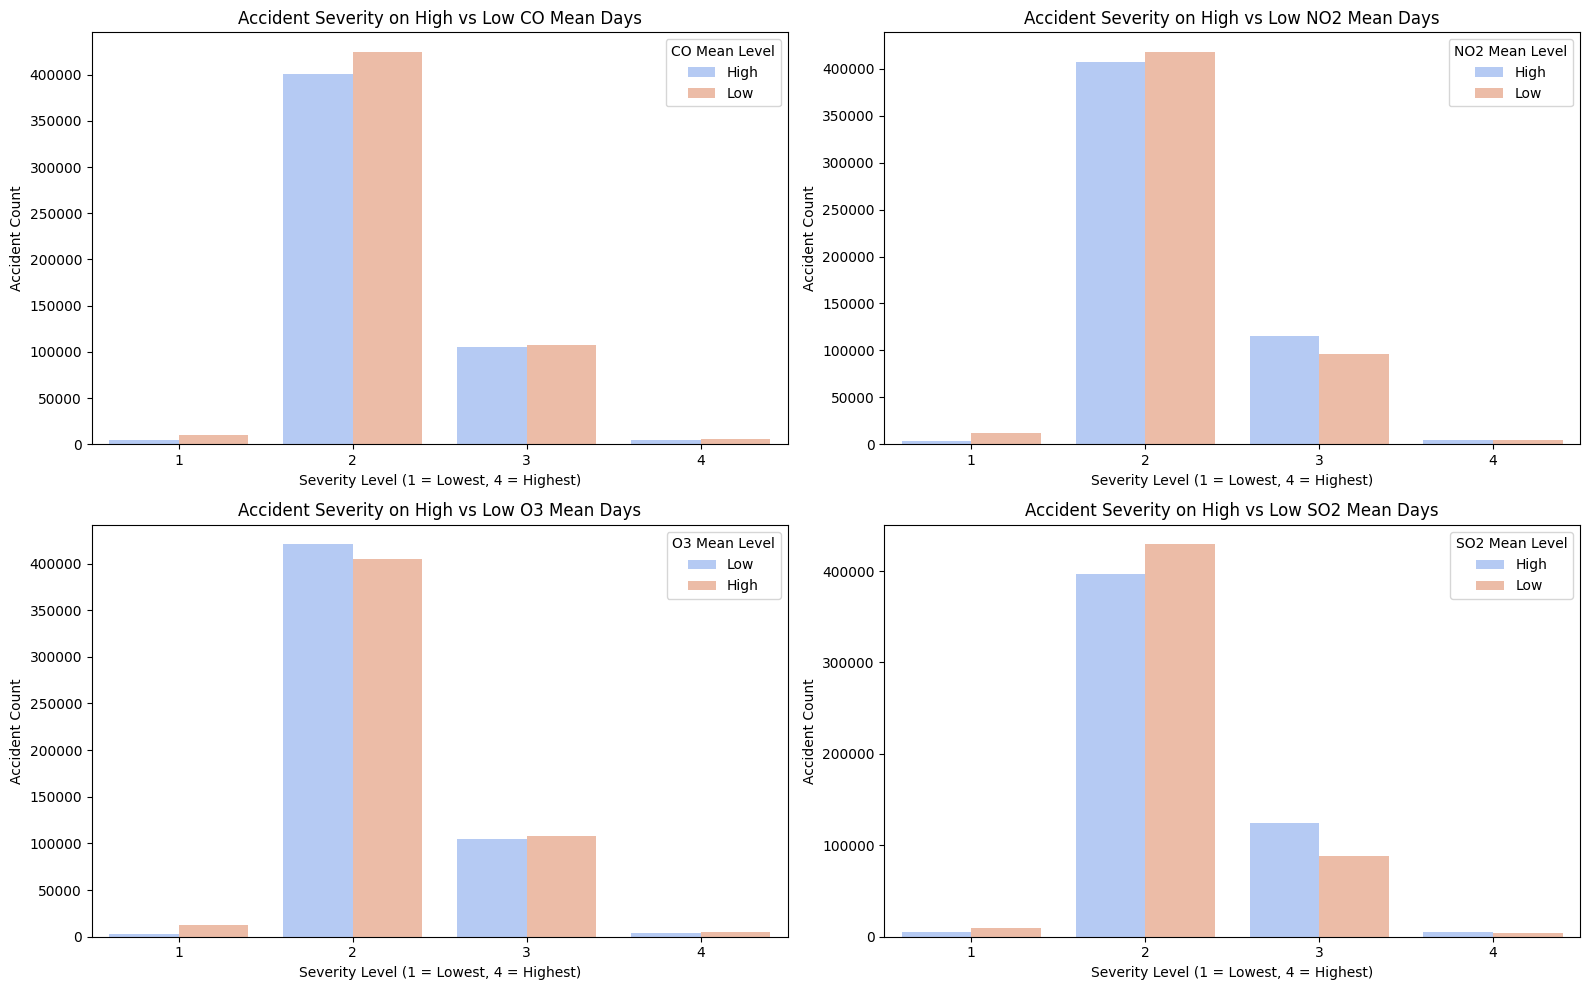

In [26]:
# Combined severity distribution plots for all pollution variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

pollution_vars = ['CO Mean', 'NO2 Mean', 'O3 Mean', 'SO2 Mean']

for i, var in enumerate(pollution_vars):
    median_val = accidents_pollution_dm[var].median()
    accidents_pollution_dm[f'{var}_Level'] = np.where(accidents_pollution_dm[var] > median_val, 'High', 'Low')
    sns.countplot(
        data=accidents_pollution_dm,
        x='Severity',
        hue=f'{var}_Level',
        palette='coolwarm',
        ax=axes[i]
    )
    axes[i].set_title(f"Accident Severity on High vs Low {var} Days")
    axes[i].set_xlabel("Severity Level (1 = Lowest, 4 = Highest)")
    axes[i].set_ylabel("Accident Count")
    axes[i].legend(title=f"{var} Level")

plt.tight_layout()
plt.show()


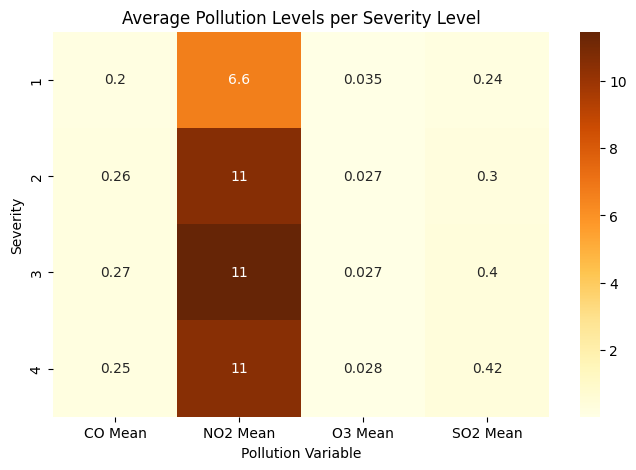

In [17]:
# Heatmap of pollution averages by severity
severity_group = accidents_pollution_dm.groupby('Severity')[pollution_vars].mean().round(3)
plt.figure(figsize=(8, 5))
sns.heatmap(severity_group, annot=True, cmap='YlOrBr')
plt.title("Average Pollution Levels per Severity Level")
plt.xlabel("Pollution Variable")
plt.ylabel("Severity")
plt.show()


In [23]:
# Top States by Average Severity and Pollution (Full State Names)
accidents_pollution_dm['Full_State'] = accidents_pollution_dm['State'].map(state_abbrev_reverse)
top_states = accidents_pollution_dm.groupby('Full_State')[['Severity', 'CO Mean', 'NO2 Mean', 'O3 Mean', 'SO2 Mean']].mean().sort_values(by='Severity', ascending=False).head(10)
display(top_states)

C:\Users\joaol\AppData\Local\Temp\ipykernel_46492\3691447863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_pollution_dm['Full_State'] = accidents_pollution_dm['State'].map(state_abbrev_reverse)


,Severity,CO Mean,NO2 Mean,O3 Mean,SO2 Mean
Full_State,,,,,
Illinois,2.667785,0.261768,8.050038,0.031330,0.822215
Mississippi,2.667727,0.181626,7.510198,0.025811,0.489681
Rhode Island,2.665012,0.204583,6.131907,0.033071,0.209893
Kentucky,2.598279,0.201021,9.092604,0.027679,0.882735
Iowa,2.503724,0.213530,6.752924,0.028239,0.062811
Connecticut,2.466258,0.247509,12.877100,0.026787,0.256672
Vermont,2.461538,0.179487,8.168239,0.025309,0.438401
Colorado,2.444336,0.337025,18.430061,0.028687,0.619444
Kansas,2.426258,0.184241,8.844674,0.025462,0.595403
